# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [1]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## Step 2: Environment Setup

In [2]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "Pendulum-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

seed = 42                  # Random seed to ensure experiment reproducibility

total_timesteps = 300_000   # Number of training steps for Expert PPO (Recommended: 40k for CartPole, 300k for Pendulum)

num_prefs = 15_000            # Number of preference samples
sample_prefs = 2_000

# ===========================================================


set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 500
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'}")


✅ Environment: Pendulum-v1 | Action space: Continuous


## Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [3]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{seed}.zip")
env.close()


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.19e+03 |
| time/              |           |
|    fps             | 8139      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.14e+03    |
| time/                   |              |
|    fps                  | 4710         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036137116 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41      

## Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [4]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)
env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 1.5
rewards.sort(key=lambda x: abs(x[1]/target - 1.0))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
pi2_model.save(f"{env_id}_pi2_model_seed{seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")
best_model_path, best_reward = max(rewards, key=lambda x: x[1])
expert_model = PPO.load(os.path.join(checkpoint_dir, best_model_path), env=env)
expert_model_path = f"{env_id}_expert_seed{seed}.zip"
expert_model.save(expert_model_path)

print(f"✅ Expert model selected: '{best_model_path}' with mean reward ≈ {best_reward:.2f}")
print(f"📦 Saved to: {expert_model_path}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_210000_steps.zip with ~-442.7 reward
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Expert model selec

## Step 5: Generate Preferences (π₁ vs π₂)

In [5]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset(seed=seed)

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.array(rewards),       # [T]
        "mask": np.array(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
env = gym.make(env_id)
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(pi2_model, env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")


🔄 Generating preference pairs: 100%|██████████| 15000/15000 [11:12<00:00, 22.29it/s]


✅ Saved 15000 preference pairs to prefs_Pendulum-v1_seed42.pkl


In [6]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## Step 7: Train DPO Policy

In [7]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=0, epochs=50, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    
    model = PPO("MlpPolicy", env, verbose=0, seed=seed, device=device)
    policy = model.policy
    policy.train()  # ensure in training mode
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]

            obs1_flat = obs1.view(-1, obs_dim)
            obs2_flat = obs2.view(-1, obs_dim)
            acts1_flat = acts1.view(-1) if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1) if is_discrete else acts2.view(-1, act_dim)

            dist1 = policy.get_distribution(obs1_flat)  # returns Categorical
            dist2 = policy.get_distribution(obs2_flat)
            lp1 = dist1.log_prob(acts1_flat).view(B, T)  # [B, T]
            lp2 = dist2.log_prob(acts2_flat).view(B, T)
            
            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = logp1_sum - logp2_sum        # [B]

            loss = F.binary_cross_entropy_with_logits(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

#with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
#    prefs = pickle.load(f)
#prefs = prefs[:sample_prefs]

#dataset = PreferenceDataset(prefs, is_discrete)
#loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

#dpo_model = train_dpo(loader, env)
#torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

In [8]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO
import copy

def train_dpo_from_ref(dataloader,ref_policy_sb3, env, beta= 0.05,  seed=42, epochs=50, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]


    ref_policy = ref_policy_sb3.policy  # frozen
    policy = copy.deepcopy(ref_policy)  # trainable

    policy.to(device)
    ref_policy.to(device)
    ref_policy.eval()  # ensure frozen

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log probs from trainable policy ---

            dist1 = policy.get_distribution(obs1_flat)
            dist2 = policy.get_distribution(obs2_flat)

            logp1 = dist1.log_prob(acts1_flat)
            logp2 = dist2.log_prob(acts2_flat)



            #logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            #logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)

            # --- Compute log probs from reference policy (frozen) ---
            with torch.no_grad():
                dist1_ref = ref_policy.get_distribution(obs1_flat)
                dist2_ref = ref_policy.get_distribution(obs2_flat)

                logp1_ref = dist1_ref.log_prob(acts1_flat)
                logp2_ref = dist2_ref.log_prob(acts2_flat)

                #logp1_ref = torch.log_softmax(ref_policy(obs1_flat), dim=-1)
                #logp2_ref = torch.log_softmax(ref_policy(obs2_flat), dim=-1)


            lp1 = (logp1 - logp1_ref).view(B, -1)  # shape [B, T]
            lp2 = (logp2 - logp2_ref).view(B, -1)


            #lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            #lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits =beta*(logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

In [11]:
def eval_policy(model, env, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0]
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns

def fine_tune_dpo_with_betas(env, dataloader, pi2_model, beta_values_from_ref, epochs=100, device='cpu'):
    rewards_from_ref = {}

    obs_dim = env.observation_space.shape[0]
    is_discrete = hasattr(env.action_space, "n")
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # ✅ Train DPO starting from π₂ and moving toward expert
    for beta in beta_values_from_ref:
        print(f"Training DPO (π₂ → Expert) with β = {beta}")

        trained_policy_from_ref = train_dpo_from_ref(
            dataloader=dataloader,
            ref_policy_sb3=pi2_model,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy_from_ref, env, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards_from_ref[beta] = avg_reward


    # ✅ Plot both curves
    plt.figure(figsize=(9, 5))
    plt.plot(list(rewards_from_ref.keys()), list(rewards_from_ref.values()), marker='o', label="DPO from π₂")
    plt.xlabel("β (temperature)")
    plt.ylabel("Final Avg Reward")
    plt.title("DPO Fine-Tuning: π₂ → Expert")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards_from_ref

Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.3830
Epoch 2/20, Loss: 0.2948
Epoch 3/20, Loss: 0.2892
Epoch 4/20, Loss: 0.2878
Epoch 5/20, Loss: 0.2845
Epoch 6/20, Loss: 0.2834
Epoch 7/20, Loss: 0.2825
Epoch 8/20, Loss: 0.2840
Epoch 9/20, Loss: 0.2818
Epoch 10/20, Loss: 0.2825
Epoch 11/20, Loss: 0.2783
Epoch 12/20, Loss: 0.2768
Epoch 13/20, Loss: 0.2773
Epoch 14/20, Loss: 0.2761
Epoch 15/20, Lo

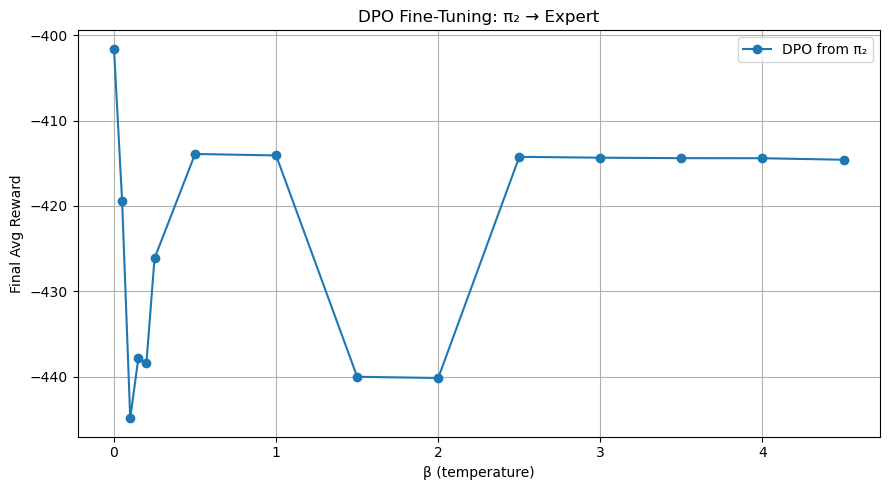

--------------------------------we use beta = {1000: 0.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.3389
Epoch 2/20, Loss: 0.2897
Epoch 3/20, Loss: 0.2855
Epoch 4/20, Loss: 0.2832
Epoch 5/20, Loss: 0.2794
Epoch 6/20, Loss: 0.2764
Epoch 7/20, Loss: 0.2742
Epoch 8/20, Loss: 0.2726
Epoch 9/20, Loss: 0.2696
Epoch 10/20, Loss: 0.2677
Epoch 11/20, Loss: 0.2664
Epoch 12/20, Loss: 0.2653
Epoch 13/

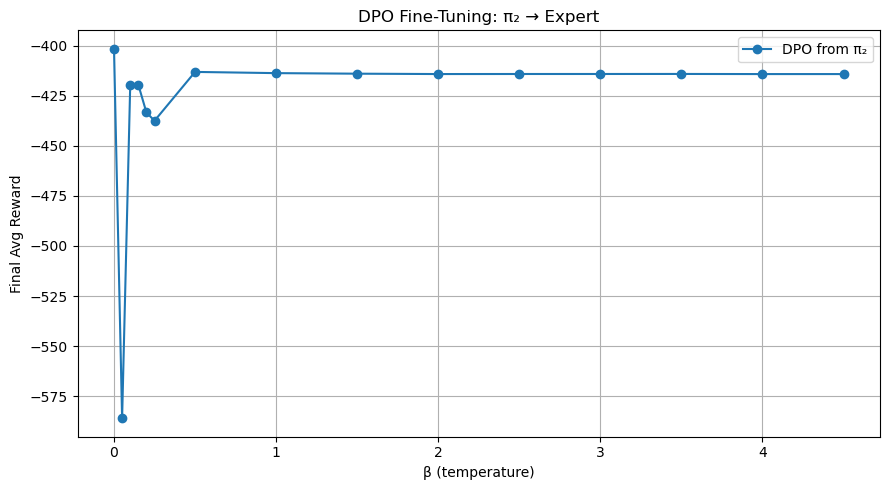

--------------------------------we use beta = {1000: 0.0, 2000: 0.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.3179
Epoch 2/20, Loss: 0.2914
Epoch 3/20, Loss: 0.2865
Epoch 4/20, Loss: 0.2821
Epoch 5/20, Loss: 0.2762
Epoch 6/20, Loss: 0.2715
Epoch 7/20, Loss: 0.2671
Epoch 8/20, Loss: 0.2631
Epoch 9/20, Loss: 0.2597
Epoch 10/20, Loss: 0.2553
Epoch 11/20, Loss: 0.2506
Epoch 12/20, Loss: 0.248

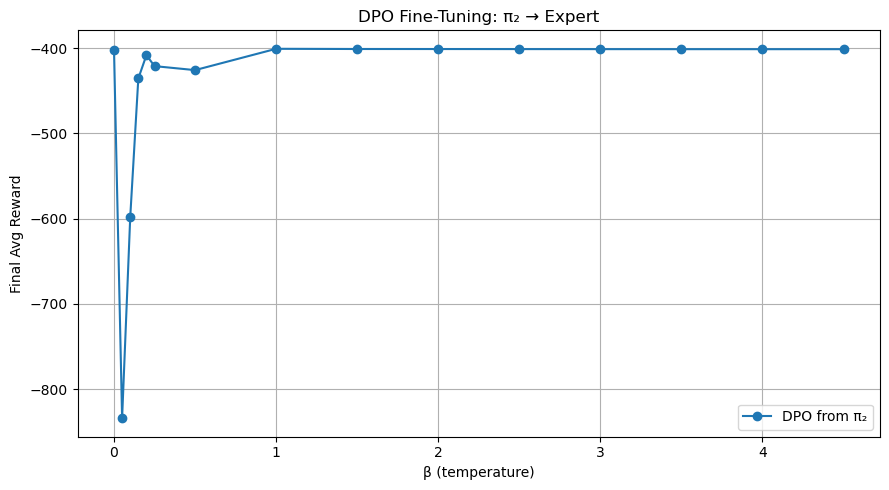

--------------------------------we use beta = {1000: 0.0, 2000: 0.0, 5000: 1.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.2992
Epoch 2/20, Loss: 0.2780
Epoch 3/20, Loss: 0.2704
Epoch 4/20, Loss: 0.2626
Epoch 5/20, Loss: 0.2567
Epoch 6/20, Loss: 0.2514
Epoch 7/20, Loss: 0.2455
Epoch 8/20, Loss: 0.2398
Epoch 9/20, Loss: 0.2349
Epoch 10/20, Loss: 0.2302
Epoch 11/20, Loss: 0.2262
Epoch 12/20, 

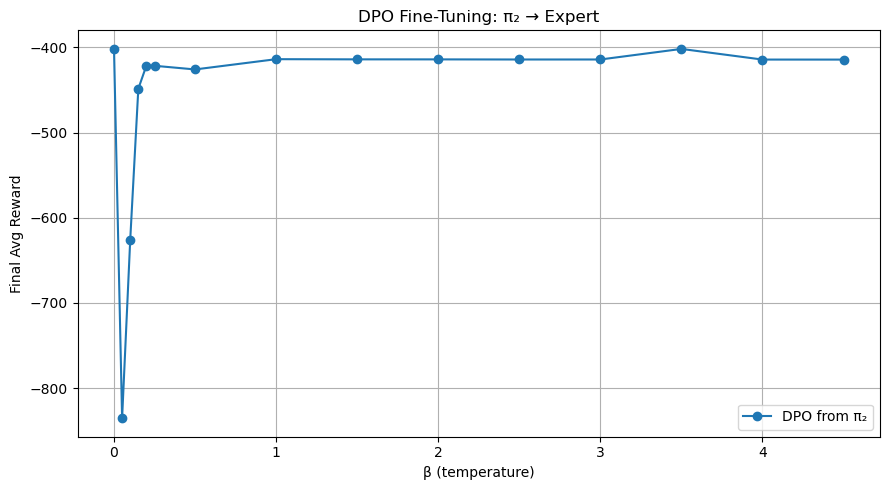

--------------------------------we use beta = {1000: 0.0, 2000: 0.0, 5000: 1.0, 8000: 0.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.3001
Epoch 2/20, Loss: 0.2777
Epoch 3/20, Loss: 0.2670
Epoch 4/20, Loss: 0.2591
Epoch 5/20, Loss: 0.2530
Epoch 6/20, Loss: 0.2455
Epoch 7/20, Loss: 0.2394
Epoch 8/20, Loss: 0.2330
Epoch 9/20, Loss: 0.2280
Epoch 10/20, Loss: 0.2237
Epoch 11/20, Loss: 0.2193
Ep

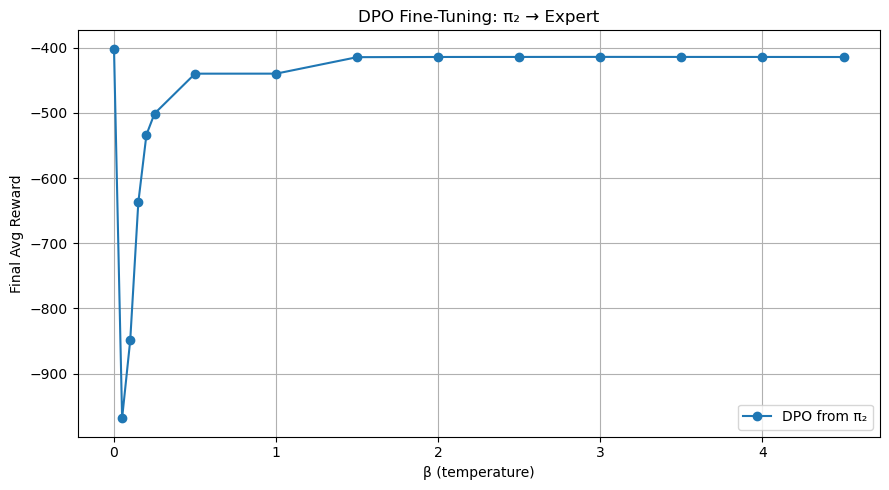

--------------------------------we use beta = {1000: 0.0, 2000: 0.0, 5000: 1.0, 8000: 0.0, 10000: 0.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6931
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6931
Epoch 5/20, Loss: 0.6931
Epoch 6/20, Loss: 0.6931
Epoch 7/20, Loss: 0.6931
Epoch 8/20, Loss: 0.6931
Epoch 9/20, Loss: 0.6931
Epoch 10/20, Loss: 0.6931
Epoch 11/20, Loss: 0.6931
Epoch 12/20, Loss: 0.6931
Epoch 13/20, Loss: 0.6931
Epoch 14/20, Loss: 0.6931
Epoch 15/20, Loss: 0.6931
Epoch 16/20, Loss: 0.6931
Epoch 17/20, Loss: 0.6931
Epoch 18/20, Loss: 0.6931
Epoch 19/20, Loss: 0.6931
Epoch 20/20, Loss: 0.6931
Final avg reward for β = 0.0: -401.57
Training DPO (π₂ → Expert) with β = 0.05
Epoch 1/20, Loss: 0.2941
Epoch 2/20, Loss: 0.2716
Epoch 3/20, Loss: 0.2586
Epoch 4/20, Loss: 0.2472
Epoch 5/20, Loss: 0.2381
Epoch 6/20, Loss: 0.2299
Epoch 7/20, Loss: 0.2218
Epoch 8/20, Loss: 0.2157
Epoch 9/20, Loss: 0.2117
Epoch 10/20, Loss: 0.2079
Epoch 11/20, Los

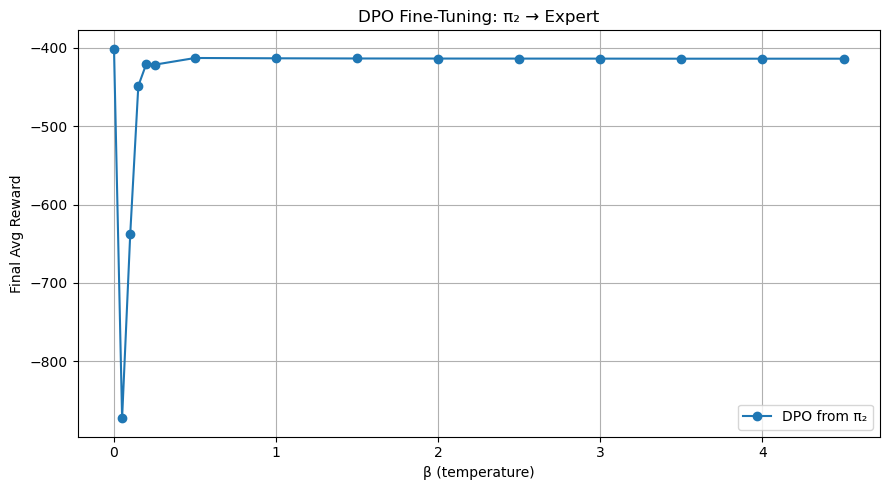

--------------------------------we use beta = {1000: 0.0, 2000: 0.0, 5000: 1.0, 8000: 0.0, 10000: 0.0, 15000: 0.0}


In [12]:
rewards = []
beta_from_ref = {}
for sample_pref in [1000, 2000, 5000, 8000, 10000, 15000]:
    with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
        prefs = pickle.load(f)
    prefs = prefs[:sample_pref]

    dataset = PreferenceDataset(prefs, is_discrete)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

    beta_values_from_ref = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.5, 5, 0.5)])
    # we could also potentially choose an adaptive beta, like : beta = beta_init * (epoch / max_epochs)

    rewards_from_ref = fine_tune_dpo_with_betas(env, loader, pi2_model,beta_values_from_ref, epochs=20)
    rewards.append(rewards_from_ref)
    beta_from_ref[sample_pref] = max(rewards_from_ref, key = rewards_from_ref.get)
    #beta_from_ref = 0.5
    print(f"--------------------------------we use beta = {beta_from_ref}")

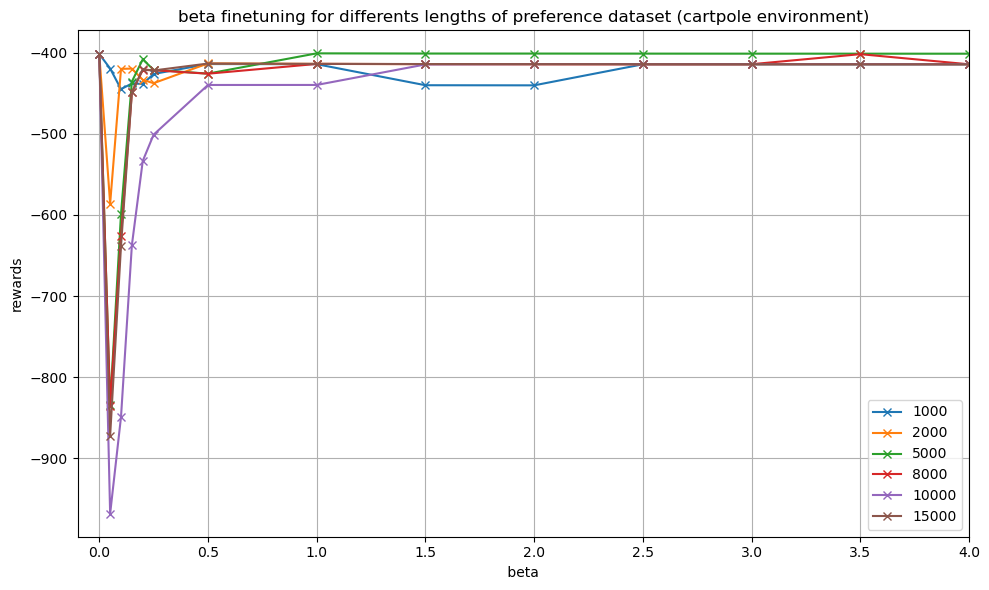

In [13]:
plt.figure(figsize=(10, 6))
sample_prefs = [1000, 2000, 5000, 8000, 10000, 15000]

# Loop through each dictionary and create a scatter plot
for i, reward_dict in enumerate(rewards):
    x = list(reward_dict.keys())
    y = list(reward_dict.values())
    plt.plot(x, y, label=f'{sample_prefs[i]}', marker='x')

# Configure the plot
plt.title("beta finetuning for differents lengths of preference dataset (cartpole environment)")
plt.xlabel(" beta ")
plt.xlim((-0.1,4))
plt.ylabel("rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()